# Kospi200

In [1]:
import numpy as np
import pandas as pd

# Crawling
from bs4 import BeautifulSoup
from selenium import webdriver

# Crawling: Request
from urllib.request import urlopen
import urllib.request
import urllib.parse
import requests
    
# conda install -c conda-forge tqdm
from tqdm import tqdm
from tqdm import tqdm_notebook

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager

# Utility
import time
import re

# Palette
import seaborn as sns
sns.set_palette("pastel")

# Jupyter Notebook
%matplotlib inline

# korean Font
matplotlib.font_manager._rebuild()
sorted([f.name for f in matplotlib.font_manager.fontManager.ttflist if f.name.startswith("Malgun")])
mpl.rc('font', family='Malgun Gothic')
mpl.rc('axes', unicode_minus=False)

# Webdriver for crawling
driver = webdriver.Chrome('C:/Users/shoseo/AppData/Local/Programs/Python/chromedriver')

### Single Page Crawling

In [2]:
driver.switch_to.window(driver.window_handles[0])
driver.get('https://finance.naver.com/sise/entryJongmok.nhn')

html = driver.page_source
soup = BeautifulSoup(html)
# soup = BeautifulSoup(html, 'html.parser')
# print(soup.prettify())

thead = []
tbody = []

for irow, row in enumerate(soup.select('table.type_1 tbody tr')):

    tbody.append({})

    # thead
    if irow == 0:

        cols = row.select('th')

        for icol, col in enumerate(cols):
            thead.append(col.get_text(strip=True))
    
    # tbody
    else:
        cols = row.select('td')

        # Exception blank column
        if len(cols) < 2:
            continue

        for icol, col in enumerate(cols):

            # 종목
            if icol == 0:
                element = col.find('a')

                # Code
                attr = element.get('href')
                match = re.compile(r"code=(\d+)").search(attr)
                code = match.group(1) if match != None else '000000'
                tbody[irow].update({'code':code})

                # title
                text = element.get_text(strip=True)
                tbody[irow].update({'종목':text})
            
            # 등락률
            elif icol == 3:

                text = col.get_text(strip=True)
                text = re.sub('[\,%]', '', text)
                text = float(text)
                tbody[irow].update({ thead[icol] : text })

            else:

                text = col.get_text(strip=True)
                text = re.sub('\D+', '', text)
                text = int(text)
                tbody[irow].update({ thead[icol] : text })

# thead
tbody[3]

{'code': '000660',
 '종목': 'SK하이닉스',
 '현재가': 97300,
 '전일비': 900,
 '등락률': -0.92,
 '거래량': 1748628,
 '거래대금(백만)': 170589,
 '시가총액(억)': 708346}

### Multiple Page Crawling

In [3]:
driver.switch_to.window(driver.window_handles[0])
driver.get('https://finance.naver.com/sise/entryJongmok.nhn')

html = driver.page_source
soup = BeautifulSoup(html)
# soup = BeautifulSoup(html, 'html.parser')
# print(soup.prettify())

# pagination
navi = []

for icol, col in enumerate(soup.select('table.Nnavi tbody td')):

    element = col.a
    href = element.get('href')
    match = re.compile(r"page=(\d+)").search(href)
    page = match.group(1) if match != None else '000000'
    navi.append(int(page))

max_page = max(navi)

thead = []
tbody = []

# loop
for page_num in np.arange(max_page):
    page_num = page_num + 1
    
    # time.sleep(.3)
    # if page_num > 3:
        # continue

    view_base = 'https://finance.naver.com/sise/entryJongmok.nhn?&page='
    view_url = view_base + str(page_num)

    # selenium
    driver.get(view_url)
    html = driver.page_source
    soup = BeautifulSoup(html)
    paging = len(tbody)

    for irow, row in enumerate(soup.select('table.type_1 tbody tr')):
        irow = irow + paging

        tbody.append({})

        # thead
        if (page_num == 1) and (irow == 0):

            cols = row.select('th')

            for icol, col in enumerate(cols):
                thead.append(col.get_text(strip=True))

        # tbody
        else:
            cols = row.select('td')

            # Exception blank column
            if len(cols) < 2:
                continue

            for icol, col in enumerate(cols):

                # 종목
                if icol == 0:
                    element = col.find('a')

                    # Code
                    attr = element.get('href')
                    match = re.compile(r"code=(\d+)").search(attr)
                    code = match.group(1) if match != None else '000000'
                    tbody[irow].update({'code':code})

                    # title
                    text = element.get_text(strip=True)
                    tbody[irow].update({'종목':text})
                
                # 등락률
                elif icol == 3:

                    text = col.get_text(strip=True)
                    text = re.sub('[\,%]', '', text)
                    text = float(text)
                    tbody[irow].update({ thead[icol] : text })

                else:

                    text = col.get_text(strip=True)
                    text = re.sub('\D+', '', text)
                    text = int(text)
                    tbody[irow].update({ thead[icol] : text })

tbody[3]

{'code': '000660',
 '종목': 'SK하이닉스',
 '현재가': 97300,
 '전일비': 900,
 '등락률': -0.92,
 '거래량': 1748628,
 '거래대금(백만)': 170589,
 '시가총액(억)': 708346}

### DataFrame

In [4]:
df = pd.DataFrame(tbody)

df = df[df.code.isnull() == False]

df['현재가'] = df['현재가'].astype(int)
df['전일비'] = df['전일비'].astype(int)
df['거래량'] = df['거래량'].astype(int)
df['거래대금(백만)'] = df['거래대금(백만)'].astype(int)
df['시가총액(억)'] = df['시가총액(억)'].astype(int)

df.index = np.arange(0, len(df))
df

,code,종목,현재가,전일비,등락률,거래량,거래대금(백만),시가총액(억)
0,005930,삼성전자,64500,100,-0.15,10686882,689953,3850510
1,000660,SK하이닉스,97300,900,-0.92,1748628,170589,708346
2,207940,삼성바이오로직스,797000,11000,-1.36,95857,76329,527335
3,051910,LG화학,720000,1000,-0.14,197392,143187,508265
4,035420,NAVER,279000,1500,-0.53,301773,84702,458295
...,...,...,...,...,...,...,...,...
195,009410,태영건설,10150,50,-0.49,161640,1648,3948
196,060980,한라홀딩스,37800,400,-1.05,15955,601,3958
197,002270,롯데푸드,339500,12500,3.82,4020,1357,3843
198,001430,세아베스틸,10250,0,0.00,49772,506,3676


### Export and Import

In [5]:
df.index = np.arange(1, len(df)+1)
df.to_csv('kospi200.csv', sep=',', encoding='utf8')

In [6]:
df = pd.read_csv('kospi200.csv', index_col=0)
df.code = df['code'].astype(str).str.zfill(6)
df.index = np.arange(0, len(df))
df.sort_values(by='시가총액(억)', ascending=False)
df.head()

,code,종목,현재가,전일비,등락률,거래량,거래대금(백만),시가총액(억)
0,005930,삼성전자,64500,100,-0.15,10686882,689953,3850510
1,000660,SK하이닉스,97300,900,-0.92,1748628,170589,708346
2,207940,삼성바이오로직스,797000,11000,-1.36,95857,76329,527335
3,051910,LG화학,720000,1000,-0.14,197392,143187,508265
4,035420,NAVER,279000,1500,-0.53,301773,84702,458295


### Visualization

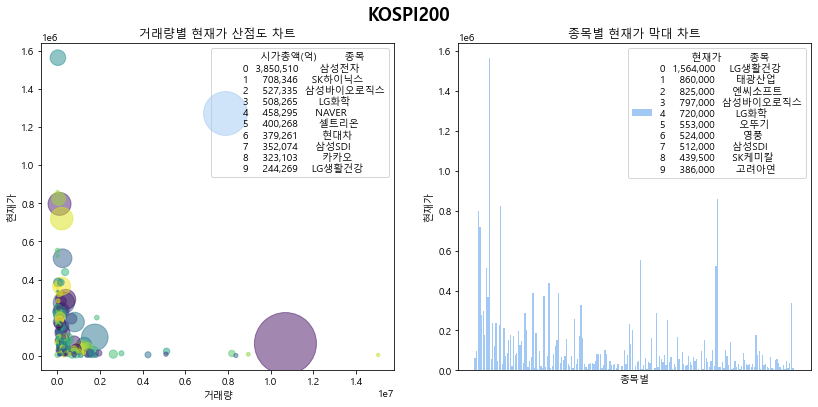

In [7]:
np.random.seed(20201119)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Axis1 Dataframe
df1 = df.sort_values(by='시가총액(억)', ascending=False).head(10)
df1 = df1[['시가총액(억)', '종목']]
df1['시가총액(억)'] = df1['시가총액(억)'].apply(lambda x: '{:,}'.format(x))
df1.index = np.arange(0, len(df1))

# Axis1 Chart
ax1 = axes[0]
area = df['시가총액(억)'] / 1000
colors = np.random.rand(200)
ax1.scatter(df['거래량'], df['현재가'], s=area, c=colors, alpha=0.5, label=df1)
ax1.set_title('거래량별 현재가 산점도 차트')
ax1.set_xlabel('거래량'); ax1.set_ylabel('현재가')
ax1.legend()

# Axis2 Dataframe
df2 = df.sort_values(by='현재가', ascending=False).head(10)
df2 = df2[['현재가', '종목']]
df2['현재가'] = df2['현재가'].apply(lambda x: '{:,}'.format(x))
df2.index = np.arange(0, len(df2))

# Axis2 Chart
ax2 = axes[1]
ax2.bar(df['종목'], df['현재가'], label=df2)
ax2.set_title('종목별 현재가 막대 차트')
ax2.set_xlabel('종목별'); ax2.set_ylabel('현재가')
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax2.legend()

# Figure
fig.suptitle("KOSPI200", fontsize=18, fontweight='bold')
fig.tight_layout(pad=3)

plt.show()